In [13]:
'''
内容：
    1. 上证50ETF期权：BSM模型算得得理论价值 与 期权实际价值之间的比较
    2. 期权隐含波动率的计算

步骤：
    1. 构建计算公式，并封装为函数：
        · 计算期权价值：bsm_call_value(s0,k,T,r,sigma)
        · 计算vega值：bsm_vega(s0,k,T,r,sigma)
        · 求隐含波动率（牛顿法）：bsm_call_imp_vol_newton(s0, k, T, r, c0, sigma_est, it = 100)
        · 求隐含波动率（二分法）：bsm_call_imp_vol_dichotomy(s0,k,t,r,c)
    2. 获取数据：
        · tushare数据
        · 本地数据
    3. 输出期权理论价值，并画出比较图（理论价值 vs 实际价值）
    4. 输出隐含波动率，并作图
'''

'\n内容：\n    1. 上证50ETF期权：BSM模型算得得理论价值 与 期权实际价值之间的比较\n    2. 期权隐含波动率的计算\n\n步骤：\n    1. 构建计算公式，并封装为函数：\n        · 计算期权价值：bsm_call_value(s0,k,T,r,sigma)\n        · 计算vega值：bsm_vega(s0,k,T,r,sigma)\n        · 求隐含波动率（牛顿法）：bsm_call_imp_vol_newton(s0, k, T, r, c0, sigma_est, it = 100)\n        · 求隐含波动率（二分法）：bsm_call_imp_vol_dichotomy(s0,k,t,r,c)\n    2. 获取数据：\n        · tushare数据\n        · 本地数据\n    3. 输出期权理论价值，并画出比较图（理论价值 vs 实际价值）\n    4. 输出隐含波动率，并作图\n'

In [3]:
import tushare as ts
import pandas as pd
import numpy as np
from math import sqrt,log,exp
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示图形的中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示图形中的负号

In [4]:
#构建所需计算公式，并封装为函数

#根据公式计算期权价值
def bsm_call_value(s0,k,T,r,sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*T )/( sigma*sqrt(T) )
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*T )/( sigma*sqrt(T) )
    value = ( s0*stats.norm.cdf( d1,0.,1. ) - k*exp( -r*T )*stats.norm.cdf( d2,0.,1 ))
    #print('cvalue',value)
    return value

#求vega
def bsm_vega(s0,k,T,r,sigma):
    d1 = log( s0/k ) + ( r + 0.5*sigma**2 )*T/( sigma*sqrt(T) )
    vega = s0*stats.norm.cdf(d1,0.,1.)*sqrt(T)
    #print('vega',vega)
    return vega

#牛顿迭代法求隐含波动率，迭代次数设为100
def bsm_call_imp_vol_newton(s0, k, T, r, c0, sigma_est, it = 100):    
    for i in range(it):
        sigma_est -= ((bsm_call_value(s0, k, T, r, sigma_est) - c0)/ 
                      bsm_vega(s0, k, T, r, sigma_est))
    return sigma_est

#二分法求隐含波动率
def bsm_call_imp_vol_dichotomy(s0,k,t,r,c):
    c_est = 0
    top = 3  #波动率上限
    floor = 0  #波动率下限
    sigma = ( floor + top )/2 #波动率初始值
    
    while abs( c - c_est ) > 1e-8:
        c_est = bsm_call_value(s0,k,t,r,sigma) 
        #根据价格判断波动率是被低估还是高估，并对波动率做修正
        if c - c_est > 0: #f(x)>0
            floor = sigma
            sigma = ( sigma + top )/2
        else:
            top = sigma
            sigma = ( sigma + floor )/2
    return sigma

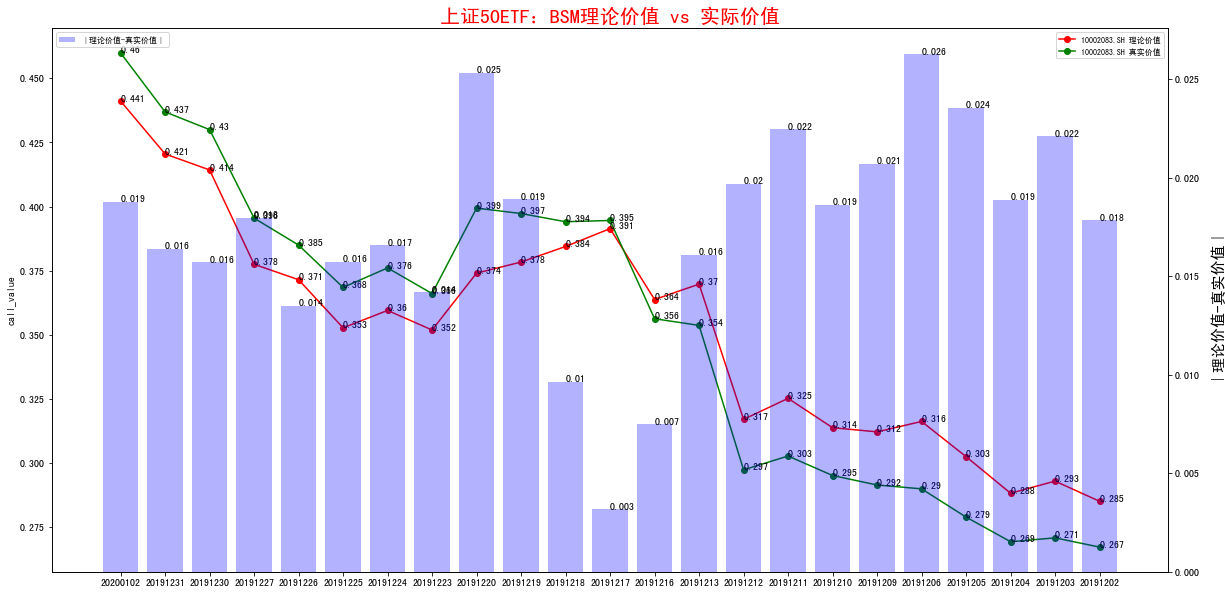

In [11]:
#认购期权合约10002083.SH；时段：20191202-20200102
if __name__ == "__main__":
    #获取数据，设置参数
    pro = ts.pro_api('bceec9776c37cadfde8020dd5f41bad8ede5c18f788716a64a0292e4') #连接tushare api
    #s0 - 上证50etf时段内每日收盘价 
    etf50_data_205 = pro.fund_daily(ts_code='510050.SH', start_date='20191202', end_date='20200102', fields='close, trade_date')
    #k - 行权价
    opt_info = pro.opt_basic(exchange='SSE', fields='ts_code, exercise_price, list_date, maturity_date')
    opt_info = opt_info[opt_info.ts_code.isin(['10002083.SH', '10002084.SH', '10002085.SH', '10002086.SH', '10002087.SH'])]     #神仙函数！！！！
    opt_info = opt_info.reset_index()
    k_2083 = 2.70
    #T - 期权期限
    T = (pd.to_datetime('20200624', format='%Y%m%d') - pd.to_datetime('20191202', format='%Y%m%d')).days     #该合约行权日为2020-06-24
    T_205 = T / 365     #天数化为年
    #r - 无风险利率（SHIBOR近似)
    r_205 = 0.028
    #sigma - 上证50ETF价格波动率
    sigma = 0.16
    
    #循环运行bsm_call_value函数，并将运行结果添加进空列表中
    bsm_call_value_2083 = [] #创建空列表
    for i in range(etf50_data_205.shape[0]):
        bsm_call_value_2083.append(bsm_call_value(etf50_data_205['close'][i], k_2083, T_205, r_205, sigma))
    #print (bsm_call_value_2083)
    #c0 - 期权最新价（真实价值）
    c0_2083 = pro.opt_daily(ts_code='10002083.SH', start_date='20191202', end_date='20200102', fields='ts_code,trade_date,close')
    delta_call_value = abs(bsm_call_value_2083 - c0_2083['close'])
    
    #画图 （柱状图为期权真实价值与理论价值差的绝对值，对应右边的y轴）
    fig = plt.figure(figsize=(20,10))
    plt.title('上证50ETF：BSM理论价值 vs 实际价值', fontsize=20, color='red')  
    ax1 = fig.add_subplot(111)
    ax1.plot(c0_2083['trade_date'], bsm_call_value_2083,'or-',label='10002083.SH 理论价值')
    for i,(_x,_y) in enumerate(zip(c0_2083['trade_date'], bsm_call_value_2083)):  
        plt.text(_x,_y,round(bsm_call_value_2083[i],3),color='black',fontsize=10,)  #将数值显示在图形上
    ax1.legend(loc=2)
    ax1.set_ylabel('call_value');
    ax3 = fig.add_subplot(111)
    ax3.plot(c0_2083['close'], 'og-',label='10002083.SH 真实价值')
    for i,(_x,_y) in enumerate(zip(c0_2083['trade_date'], c0_2083['close'])):  
        plt.text(_x,_y,round(c0_2083['close'][i],3),color='black',fontsize=10,)  #将数值显示在图形上
    ax3.legend(loc=2)
    plt.legend(prop={'family':'SimHei','size':8})  #设置中文
    ax2 = ax1.twinx() # this is the important function  
    plt.bar(c0_2083['trade_date'],delta_call_value,alpha=0.3,color='blue',label='｜理论价值-真实价值｜')  
    for i,(_x,_y) in enumerate(zip(c0_2083['trade_date'], delta_call_value)):  
        plt.text(_x,_y,round(delta_call_value[i],3),color='black',fontsize=10,)  #将数值显示在图形上
    ax2.legend(loc=1)
    ax2.set_ylabel('｜理论价值-真实价值｜', fontsize=15);
    plt.legend(prop={'family':'SimHei','size':8},loc="upper left") 
    plt.xticks(c0_2083['trade_date'])
    plt.show()


imp_vol_newton_16:
[0.3638689603157307, 0.3647065048442553, 0.33796965226626546, 0.3087508280418194, 0.29010352112059345, 0.27704783086782625, 0.2678504434116786, 0.27958298121452063, 0.2815159982582914, 0.28924778675106017, 0.2948778490238011, 0.3001603015476018, 0.30799521991305795]
imp_vol_dichotomy_16:
[0.3638690114021301, 0.3647065758705139, 0.33796969056129456, 0.3087505102157593, 0.290103480219841, 0.2770475149154663, 0.2678511142730713, 0.2795829623937607, 0.28151603043079376, 0.2892477214336395, 0.29487812519073486, 0.3001604676246643, 0.30799537897109985]
-------------------------------------------------------------------------------------------------------------------------------------
imp_vol_newton_51:
[0.2663830055838, 0.2623349770104388, 0.25886692974504383, 0.25514765329363565, 0.25388257585478174, 0.25112748137747287, 0.25311127192458244, 0.25282431711916714, 0.25334527303228827]
imp_vol_dichotomy_51:
[0.26638298481702805, 0.26233501732349396, 0.25886694341897964, 0.25

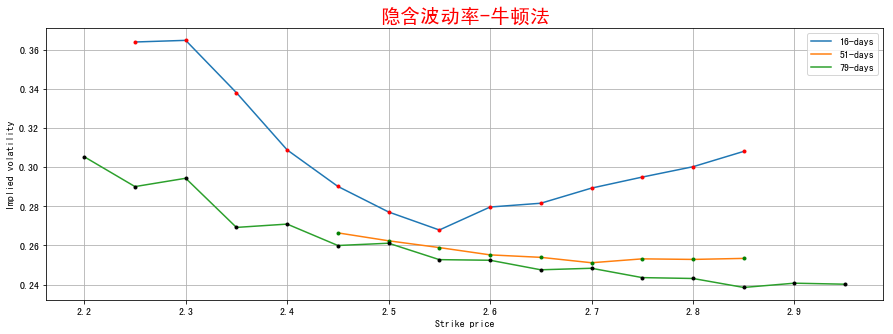

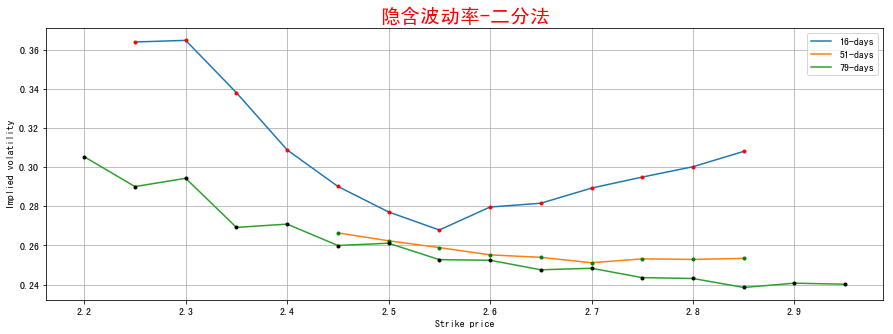

In [12]:
#期权隐含波动率的计算，3个样本分别为：到期期限16天，51天，79天
if __name__ == "__main__":
    #读取行情数据(数据文件从本地读取，并另存在邮件附件压缩包中，以及github仓库中)
    call_50etf_16 = pd.read_csv('/Users/mac/.spyder-py3/金工作业/call_50etf_16.csv')
    call_50etf_51 = pd.read_csv('/Users/mac/.spyder-py3/金工作业/call_50etf_51.csv')
    call_50etf_79 = pd.read_csv('/Users/mac/.spyder-py3/金工作业/call_50etf_79.csv')

    #取期权价格和行权价
    price_16 = call_50etf_16['最新价']
    k_16 = call_50etf_16['行权价']
    price_51 = call_50etf_51['最新价']
    k_51 = call_50etf_51['行权价']
    price_79 = call_50etf_79['最新价']
    k_79 = call_50etf_79['行权价']

    #到期时间年化
    t_16 = 16/365
    t_51 = 51/365
    t_79 = 79/365

    #标的初始价格
    s0 = 2.533
    #无风险利率，用shibor近似
    rf = 0.025    

    #用两种方法分别求三只期权的隐含波动率，并打印
    sigma_init=1
    sigma_16_newton=[]
    sigma_16_dichotomy=[]
    for i in range(call_50etf_16.shape[0]):
        sigma_16_newton.append(bsm_call_imp_vol_newton(s0,k_16[i],t_16,rf,price_16[i],sigma_init)) #牛顿法
        sigma_16_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_16[i],t_16,rf,price_16[i])) #二分法

    print('imp_vol_newton_16:')
    print(sigma_16_newton)
    print('imp_vol_dichotomy_16:')
    print(sigma_16_dichotomy)
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    #
    sigma_51_newton=[]
    sigma_51_dichotomy=[]
    for i in range(call_50etf_51.shape[0]):
        sigma_51_newton.append(bsm_call_imp_vol_newton(s0,k_51[i],t_51,rf,price_51[i],sigma_init))
        sigma_51_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_51[i],t_51,rf,price_51[i]))

    print('imp_vol_newton_51:')    
    print(sigma_51_newton)
    print('imp_vol_dichotomy_51:')
    print(sigma_51_dichotomy)
    print('-------------------------------------------------------------------------------------------------------------------------------------')

    #
    sigma_79_newton=[]
    sigma_79_dichotomy=[]
    for i in range(call_50etf_79.shape[0]):
        sigma_79_newton.append(bsm_call_imp_vol_newton(s0,k_79[i],t_79,rf,price_79[i],sigma_init))
        sigma_79_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_79[i],t_79,rf,price_79[i]))

    print('imp_vol_newton_79:')     
    print(sigma_79_newton)
    print('imp_vol_dichotomy_79:')
    print(sigma_79_dichotomy)
    print('-------------------------------------------------------------------------------------------------------------------------------------')


    #绘制牛顿法求解的波动率曲线
    plt.figure(figsize=(15,5))
    plt.title('隐含波动率-牛顿法', fontsize=20, color='red')  
    plt.plot(k_16,sigma_16_newton,label='16-days',lw=1.5,)
    plt.plot(k_16,sigma_16_newton,'r.')
    plt.plot(k_51,sigma_51_newton,label='51-days',lw=1.5)
    plt.plot(k_51,sigma_51_newton,'g.')
    plt.plot(k_79,sigma_79_newton,label='79-days',lw=1.5)
    plt.plot(k_79,sigma_79_newton,'k.')

    plt.grid(True)
    plt.xlabel('Strike price')
    plt.ylabel('Implied volatility')
    plt.legend()
    plt.show()


    #绘制二分法求解的波动率曲线
    plt.figure(figsize=(15,5))
    plt.title('隐含波动率-二分法', fontsize=20, color='red')  
    plt.plot(k_16,sigma_16_dichotomy,label='16-days',lw=1.5,)
    plt.plot(k_16,sigma_16_dichotomy,'r.')
    plt.plot(k_51,sigma_51_dichotomy,label='51-days',lw=1.5)
    plt.plot(k_51,sigma_51_dichotomy,'g.')
    plt.plot(k_79,sigma_79_dichotomy,label='79-days',lw=1.5)
    plt.plot(k_79,sigma_79_dichotomy,'k.')

    plt.grid(True)
    plt.xlabel('Strike price')
    plt.ylabel('Implied volatility')
    plt.legend()
    plt.show()